# Data preparation, scaling, and LSTM model, and vizualization of model predictions
* time period can be changed by adjusting start variable
* time length of predictions (validation set) can be changed by adjusting the percent in training_data_len
    * currently set to beginning of 2021, and 75%



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
3/3 [==============================] - 1s 14ms/step


/var/folders/qx/hg7vj1615w1327p4flbrsrnm0000gp/T/ipykernel_42943/3364771226.py:111: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



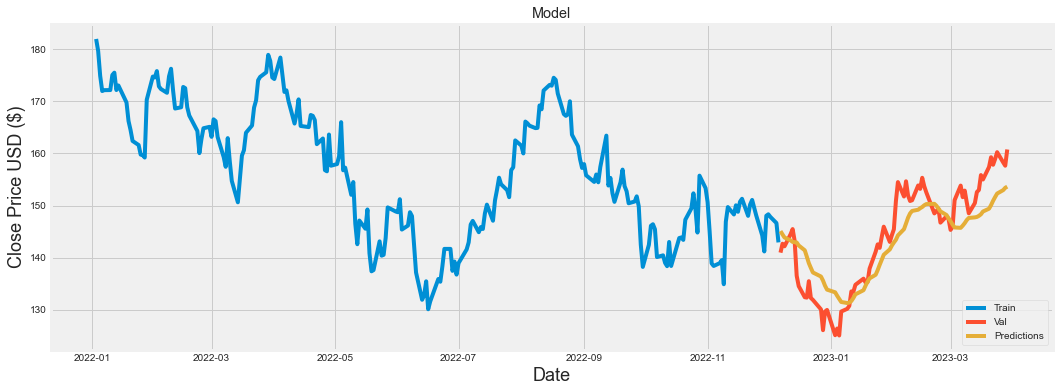

In [89]:
import pandas as pd
import numpy as np
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

yf.pdr_override()

# The tech stocks we'll use for this analysis
tech_list = ['AAPL']

# Set up End and Start times for data grab

end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)

for stock in tech_list:
    globals()[stock] = yf.download(stock, start, end)
    
company_list = [AAPL]
company_name = ["APPLE"]

for company, com_name in zip(company_list, company_name):
    company["company_name"] = com_name
    
df = pd.concat(company_list, axis=0)
df.tail(10)

# get stock quote, specify start date ****
df = pdr.get_data_yahoo('AAPL', start='2022-01-01', end=datetime.now())

# create a dataframe with close
data = df.filter(['Close'])

# convert dataframe to numpy array
dataset = data.values

# get the # of rows to train the model on, how much to save for validation ***
training_data_len = int(np.ceil( len(dataset) * .75 ))

# scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

# create the training data set 
train_data = scaled_data[0:int(training_data_len), :]

# split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
        
# convert x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# train the model
model.fit(x_train, y_train, batch_size=1, epochs=1)

# create a new array containing scaled values from index 1543 to 2002 
test_data = scaled_data[training_data_len - 60: , :]

# create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])
    
# convert the data to a numpy array
x_test = np.array(x_test)

# reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))


# plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions

# visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()





# Actual vs predicted prices


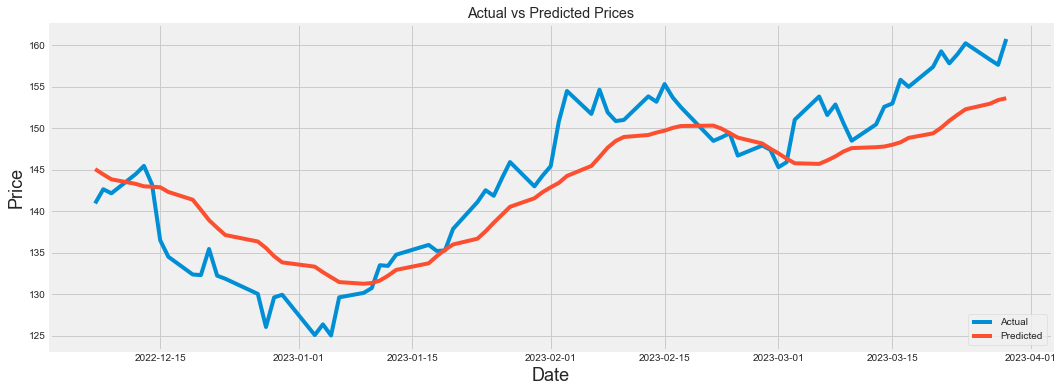

In [90]:
# create a new dataframe for comparison
compare_df = pd.DataFrame({'Date': valid.index, 'Actual': valid['Close'], 'Predicted': valid['Predictions']})
compare_df = compare_df.set_index('Date')

# plot the actual and predicted values side by side
plt.figure(figsize=(16,6))
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Price', fontsize=18)
plt.plot(compare_df.index, compare_df['Actual'])
plt.plot(compare_df.index, compare_df['Predicted'])
plt.legend(['Actual', 'Predicted'], loc='lower right')
plt.show()



## Day by day analysis, along with accuracy given by if the signs matched on a given day (increase or decrease), next want to create a strategy to buy based off if the price the next day is higher, and test with actual close prices

In [82]:
# Create DataFrame of actual and predicted prices for each day in validation set
predictions_df = pd.DataFrame({'Date': valid.index, 
                               'Actual Close': valid['Close'], 
                               'Predicted Close': valid['Predictions'],
                               'Actual Percent Change': valid['Close'].pct_change(),
                               'Predicted Percent Change': valid['Predictions'].pct_change()})

# Create binary column for sign match
predictions_df['Sign Match'] = np.where(np.sign(predictions_df['Actual Percent Change']) == np.sign(predictions_df['Predicted Percent Change']), 1, 0)

# Calculate accuracy as the average of the Sign Match column
accuracy = predictions_df['Sign Match'].mean()

# Format numbers with two decimal places
predictions_df = predictions_df.style.format({'Actual Close': '{:.2f}', 
                                               'Predicted Close': '{:.2f}',
                                               'Actual Percent Change': '{:.2%}',
                                               'Predicted Percent Change': '{:.2%}',
                                               'Sign Match': '{:.0f}'})

# Display DataFrame and accuracy
display(predictions_df)
print(f'Accuracy: {accuracy:.2%}')


,Date,Actual Close,Predicted Close,Actual Percent Change,Predicted Percent Change,Sign Match
Date,,,,,,
2022-12-07 00:00:00,2022-12-07 00:00:00,140.94,146.73,nan%,nan%,0
2022-12-08 00:00:00,2022-12-08 00:00:00,142.65,146.13,1.21%,-0.41%,0
2022-12-09 00:00:00,2022-12-09 00:00:00,142.16,145.56,-0.34%,-0.39%,1
2022-12-12 00:00:00,2022-12-12 00:00:00,144.49,145.03,1.64%,-0.36%,0
2022-12-13 00:00:00,2022-12-13 00:00:00,145.47,144.74,0.68%,-0.20%,0
2022-12-14 00:00:00,2022-12-14 00:00:00,143.21,144.69,-1.55%,-0.04%,1
2022-12-15 00:00:00,2022-12-15 00:00:00,136.50,144.63,-4.69%,-0.04%,1
2022-12-16 00:00:00,2022-12-16 00:00:00,134.51,144.11,-1.46%,-0.36%,1
2022-12-19 00:00:00,2022-12-19 00:00:00,132.37,143.23,-1.59%,-0.61%,1


Accuracy: 55.84%
